My prompt: ok, i'm trying to come up with an expression for melt rate at the top of a permafrost table. right now i have 
melt rate = (1/L) * (irradiance + Ks*dT/dz + Q), where L is latent heat of fusion, irradiance is the energy coming from the sun, Ks is the thermal conductivity of the frozen soil, dT/dz is the temperature gradient in the frozen soil, and Q is some internal heat dissipation, which is either 0 or related to some water flow expression I have. I am trying to predict melt rate of the permafrost over the year at a high latitude, such that the sun isn't shining until like March, peaks in July, then goes away in like November. How can i get it so that the soil melts slowly when it's colder, faster when it's hotter, and then maybe like freezes again (negative melt rate) when the sun gets weaker again? 

Answer: Your current expression for melt rate already incorporates the major heat flux components, but it doesn't explicitly account for the phase change dynamics that govern melting and refreezing over the year. You want the melt rate to be positive when energy input is high and negative when conditions favor refreezing. Here's how you can refine the expression:

Considerations:
Seasonal Temperature and Solar Cycle: Since you're modeling high-latitude permafrost, your irradiance term should be time-dependent, e.g., modeled as a sinusoidal function representing the seasonal solar cycle.
Nonlinear Response to Temperature: The melt rate should increase nonlinearly with temperature above 0°C and decrease (or reverse) when temperatures drop below freezing.
Latent Heat Buffering: The system should incorporate a threshold around 0°C so that small fluctuations in temperature near freezing don't cause unrealistic instantaneous melting/freezing.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
flow_speed = 1e-2

slope = np.arctan(np.deg2rad(np.arange(0,90,2.5)))
# Q_paper = 1e2
# Q = (Q_paper * 0.001) / delta_x # turn it into kilojoules per second, and also m2 instead of m3? 

Q_rushlow = 13.2
# Q = (Q_rushlow * 0.001) # turn it into kilojoules per second, 

rho_w = 1000
g = 9.8
Q_calc = (flow_speed * rho_w * g * slope)


In [14]:
def melt_rate(t_seconds,
                S0=700, # This is twice as high as it should be but I couldn't get the thaw to be deep enough
                L = 334E3 * 0.5, # ice content modulated by porosity?  # 334000,
                Ks=2.73, 
                dTdz=-20.0, 
                Q=0, 
                Tm=0, 
                k=1, 
                T_mean=-2, 
                T_range=15, 
                rho_ice=917):
    """
    Computes the melt rate at the permafrost table using time in seconds.
    t_seconds : time in seconds
    S0 : peak solar irradiance (W/m^2)
    L : latent heat of fusion (J/kg)
    Ks : thermal conductivity of frozen soil (W/m*K)
    dTdz : temperature gradient in the frozen soil (K/m)
    Q : internal heat dissipation (W/m^2)
    Tm : melting temperature threshold (°C)
    k : steepness of the melting transition
    T_mean : mean annual temperature (°C)
    T_range : annual temperature range (°C)
    rho_ice : density of ice (kg/m³)
    """
    seconds_per_year = 365 * 86400  # Total seconds in a year
    doy_shift_seconds = 180 * 86400  # Shift in seconds

    # Seasonal solar irradiance variation (in seconds)
    irradiance = S0 * np.cos(2 * np.pi * (t_seconds - doy_shift_seconds) / seconds_per_year)

    # Seasonal temperature variation (in seconds)
    T_surface = T_mean + (T_range / 2) * np.cos(2 * np.pi * (t_seconds - doy_shift_seconds) / seconds_per_year)

    # Compute total energy flux
    energy_flux = irradiance + Ks * dTdz + Q

    # Smooth melt function using logistic function
    melt_factor = 1 / (1 + np.exp(-k * (T_surface - Tm)))

    # Convert energy flux to melt rate in meters per second
    # PLus or minus if you care about this "melt factor" fudge
    # melt_rate_per_second = (energy_flux / L) * melt_factor
    melt_rate_per_second = (energy_flux / L)#* melt_factor

    return melt_rate_per_second



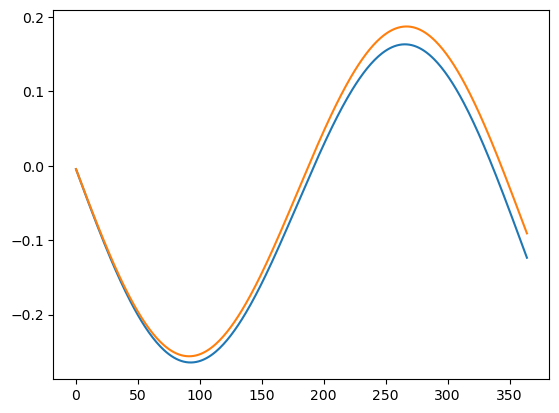

In [15]:
# Simulate over a full year in seconds
t_seconds = np.linspace(0, 365 * 86400, 365)  # One point per day, but in seconds
melt_rates = melt_rate(t_seconds) * 86400  # Convert back to meters per day for plotting

plt.plot(np.cumsum(melt_rate(t_seconds, Q=0)))
plt.plot(np.cumsum(melt_rate(t_seconds, Q=15)))


In [21]:
seconds_per_year = 365 * 86400  # Total seconds in a year
doy_shift_seconds = 180 * 86400  # Shift in seconds
S0=700
irradiance = S0 * np.cos(2 * np.pi * (t_seconds - doy_shift_seconds) / seconds_per_year)
Q=0
dTdz=-20.0
Ks=2.73
L = 334E3 * 0.5
energy_flux = irradiance + Ks * dTdz + Q

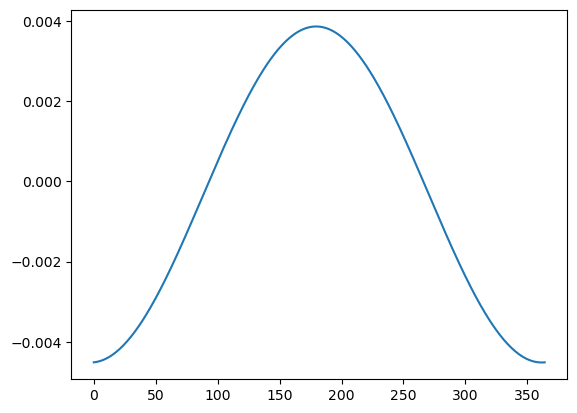

In [24]:
plt.plot(energy_flux/L)